In [1]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
project_dir='/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[
    (GoodSubs['FD_exclusion']<=2)&(
        GoodSubs['ABS_exclusion']<=1)&(
        GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)

HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
subs['MB'] =  [int(re.search('mb(.*)me',str(x)).group(1)) for x in subs['acq']]
subs['ME'] =  [int(re.search('me(.*)',str(x)).group(1)) for x in subs['acq']]

print(" There are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                          len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))
  

We collected and downloaded data from 43 subjects
 There are 32 number of subjects who passed the exclusion criteria.
 19 Were collected using a 64 channel headcoil and 13 with a 20 channel headcoil


# Count Subjects with full L1 output

In [3]:
act=[]
ppi=[]
L2ppi=[]
for index,row in subs.iterrows():
    sub=row['sub']
    acq=row['acq']
    act.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    L2ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L2_task-sharedreward_model-1_type-ppi_seed-VS_thr5_sm-4.gfeat/cope10.feat/stats/cope1.nii.gz'%(sub)))

subs['L1act']=act
subs['L1ppi']=ppi
subs['L2ppi']=L2ppi
#display(subs)
subs[subs['L2ppi']==False].head()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,3,1,False,False,False
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,6,4,False,False,False
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,1,1,False,False,False
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,3,4,False,False,False
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,1,4,False,False,False


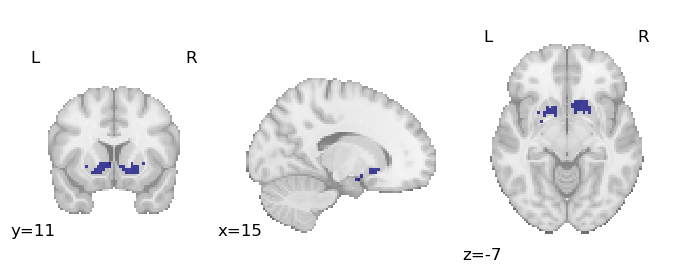

In [4]:
r_vs='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
l_vs='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
F_VS=math_img('img1+img2',img1=r_vs,img2=l_vs)
plotting.plot_roi(F_VS,draw_cross=False)
plt.savefig("../derivatives/figures/assets/mask_VS-func.svg")
plt.show()

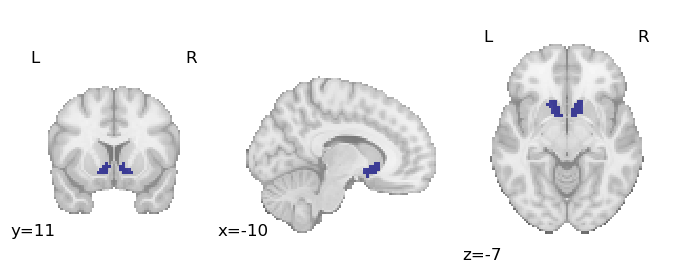

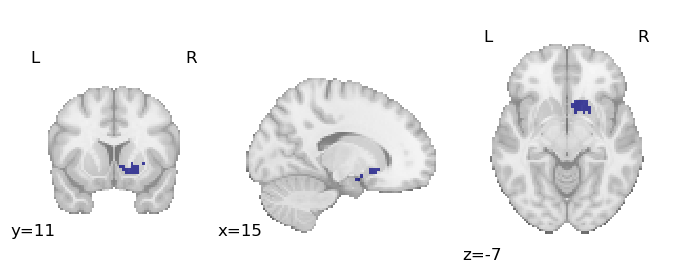

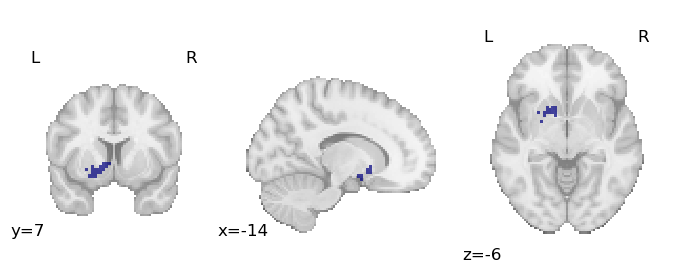

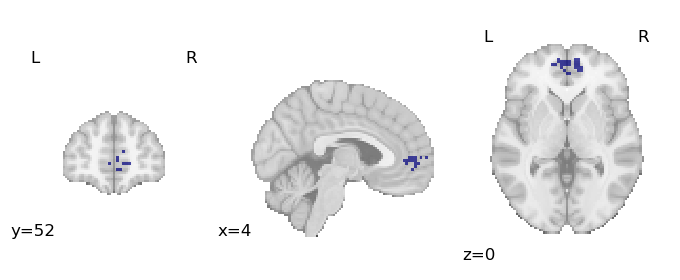

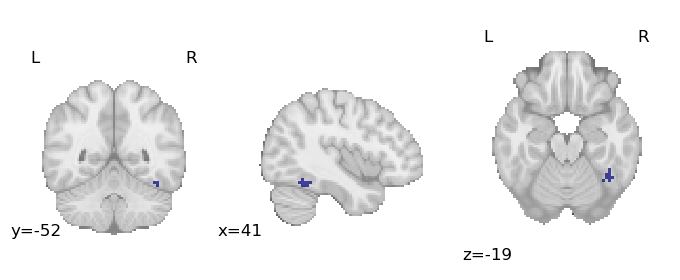

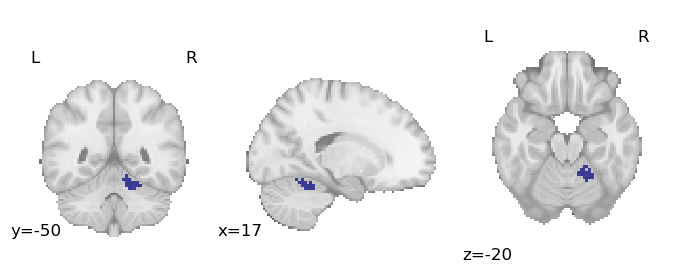

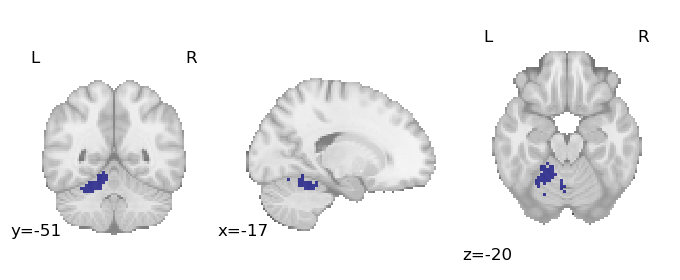

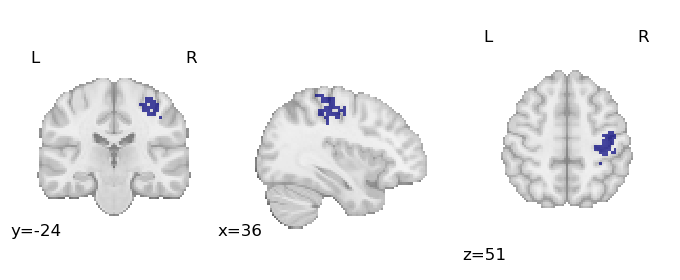

In [5]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/FFA_voxel-thresh-mask.nii.gz'
    sCerb_mask='../masks/right-cerb_voxel-thresh.nii.gz'
    iCerb_mask='../masks/left-cerb_voxel-thresh.nii.gz'
    motor_mask='../masks/right-motor_voxel-thresh.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        #mask_name=re.search('ROI-(.*)_cname',mask).group(1)
        #print(mask_name)
        mask_name='unknown'
        plotting.plot_roi(mask,draw_cross=False)
        plt.savefig("../derivatives/figures/assets/mask_%s.svg"%(mask_name))
        plt.show()
mask_list=[F_VS,VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]


# VS- Reward Activiation

In [6]:
#masker= NiftiMasker(mask_img=VS_mask)
masker= NiftiMasker(mask_img=F_VS)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope13.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/zstat13.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope13.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(VS_Reward_cope=copes,
               VS_Reward_zstats=zstats,
               VS_Reward_varcope=varcopes)

100%|█████████████████████████████████████████| 190/190 [02:09<00:00,  1.47it/s]


In [7]:
subs

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi,VS_Reward_cope,VS_Reward_zstats,VS_Reward_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,3,1,False,False,False,327.953735,1.291766,81046.421875
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,6,4,False,False,False,175.790710,0.558407,92241.953125
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,1,1,False,False,False,-6.943519,0.089437,283341.625000
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,3,4,False,False,False,81.670906,0.271775,92493.953125
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,1,4,False,False,False,17.223320,0.091128,218973.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,32,sub-12042,mb3me1,0,0.882717,0.166905,False,False,False,HeadNeck_20,3,1,False,False,False,147.772766,0.417614,153215.093750
186,33,sub-12042,mb6me4,0,0.465247,0.086336,False,False,False,HeadNeck_20,6,4,False,False,False,181.291000,0.462681,191288.437500
187,34,sub-12042,mb1me4,0,0.384643,0.091856,False,False,False,HeadNeck_20,1,4,False,False,False,221.885605,0.428697,368392.187500
188,35,sub-12042,mb6me1,0,0.562190,0.120174,False,False,False,HeadNeck_20,6,1,False,False,False,12.306326,-0.005160,112309.117188


# Display Reward Activation by Acquisition

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: VS_Reward_zstats
No. Observations: 108     Method:             REML            
No. Groups:       18      Scale:              0.2397          
Min. group size:  6       Log-Likelihood:     -84.9113        
Max. group size:  6       Converged:          Yes             
Mean group size:  6.0                                         
----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept    0.106      0.174    0.610   0.542   -0.236    0.448
MB           0.118      0.045    2.654   0.008    0.031    0.206
ME           0.051      0.060    0.859   0.391   -0.066    0.169
MB:ME       -0.024      0.015   -1.588   0.112   -0.054    0.006
Group Var    0.000      0.039                                   
==============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: VS_Reward_cope
No. Observations: 108     Method:             REML          
No. Groups:       18      Scale:              27942.9787    
Min. group size:  6       Log-Likelihood:     -691.9759     
Max. group size:  6       Converged:          Yes           
Mean group size:  6.0                                       
-------------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-------------------------------------------------------------
Intercept   67.361    59.688   1.129  0.259  -49.626  184.347
MB          19.960    15.215   1.312  0.190   -9.860   49.781
ME          26.324    20.435   1.288  0.198  -13.728   66.377
MB:ME       -7.090     5.219  -1.359  0.174  -17.318    3.139
Group Var  235.217    10.976                                 
============================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: VS_Reward_zstats
No. Observations: 75      Method:             REML            
No. Groups:       13      Scale:              0.1747          
Min. group size:  5       Log-Likelihood:     -52.9222        
Max. group size:  6       Converged:          Yes             
Mean group size:  5.8                                         
----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept    0.018      0.185    0.099   0.921   -0.345    0.381
MB           0.082      0.046    1.807   0.071   -0.007    0.172
ME           0.066      0.061    1.076   0.282   -0.054    0.187
MB:ME       -0.023      0.016   -1.441   0.150   -0.053    0.008
Group Var    0.022      0.056                                   
==============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: VS_Reward_cope
No. Observations: 75      Method:             REML          
No. Groups:       13      Scale:              27999.0330    
Min. group size:  5       Log-Likelihood:     -478.4156     
Max. group size:  6       Converged:          Yes           
Mean group size:  5.8                                       
------------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------
Intercept      23.292   74.203  0.314 0.754 -122.143 168.728
MB             20.480   18.263  1.121 0.262  -15.313  56.274
ME             29.665   24.590  1.206 0.228  -18.530  77.859
MB:ME          -6.886    6.283 -1.096 0.273  -19.201   5.430
Group Var    3526.020   22.863                              
============================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM    Dependent Variable:    VS_Reward_zstats
No. Observations:     183        Method:                REML            
No. Groups:           31         Scale:                 0.2187          
Min. group size:      5          Log-Likelihood:        -139.0239       
Max. group size:      6          Converged:             Yes             
Mean group size:      5.9                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.016    0.202  0.079 0.937 -0.381  0.413
HeadCoil[T.HeadNeck_64]        0.090    0.263  0.344 0.731 -0.424  0.605
MB                             0.082    0.051  1.616 0.106 -0.018  0.182
MB:HeadCoil[T.HeadNeck_64]     0.036    0.066  0.540 0.589 -0.094  0.166
ME                             0.066    0.069  0.961 0.336 -0.069  0.201
ME:HeadCoil[T.HeadNeck_64]    -0.015    0.089 -0.163 0.870 -0.190  0.160
MB:ME                         -0.022    0.018 -1.259 0.208 -0.056  0.012
MB:ME:HeadCoil[T.HeadNeck_64] -0.002    0.023 -0.096 0.924 -0.047  0.043
Group Var                      0.003    0.025                           
========================================================================

"""

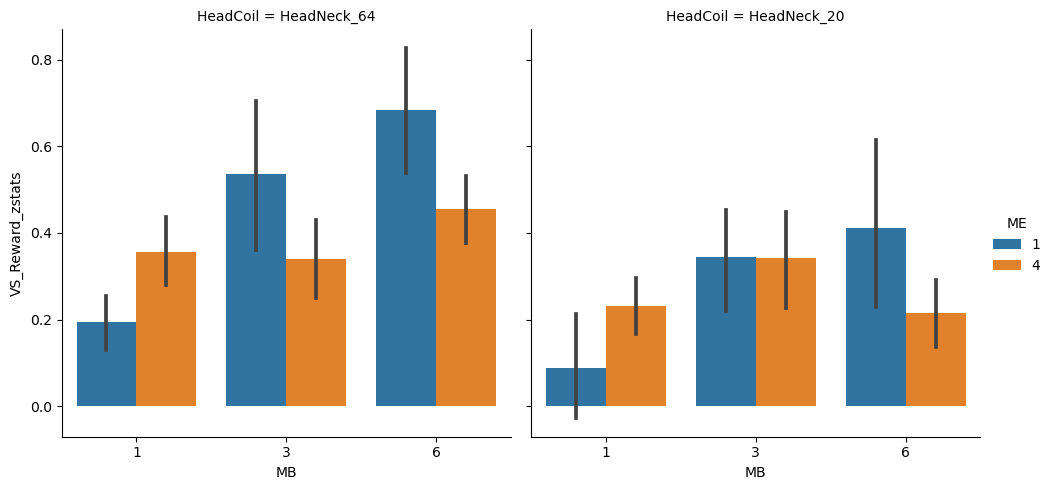

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                   MixedLM      Dependent Variable:      VS_Reward_cope
No. Observations:        183          Method:                  REML          
No. Groups:              31           Scale:                   28009.4085    
Min. group size:         5            Log-Likelihood:          -1170.8461    
Max. group size:         6            Converged:               Yes           
Mean group size:         5.9                                                 
-----------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                       22.428   73.093  0.307 0.759 -120.831 165.688
HeadCoil[T.HeadNeck_64]         44.932   94.787  0.474 0.635 -140.847 230.711
MB                              20.520   18.256  1.124 0.261  -15.260  56.300
MB:HeadCoil[T.HeadNeck_64]      -0.560   23.776 -0.024 0.981  -47.160  46.041
ME                              29.642   24.578  1.206 0.228  -18.529  77.813
ME:HeadCoil[T.HeadNeck_64]      -3.317   31.979 -0.104 0.917  -65.995  59.360
MB:ME                           -6.753    6.280 -1.075 0.282  -19.061   5.555
MB:ME:HeadCoil[T.HeadNeck_64]   -0.337    8.169 -0.041 0.967  -16.348  15.674
Group Var                     1510.918   10.914                              
=============================================================================

"""

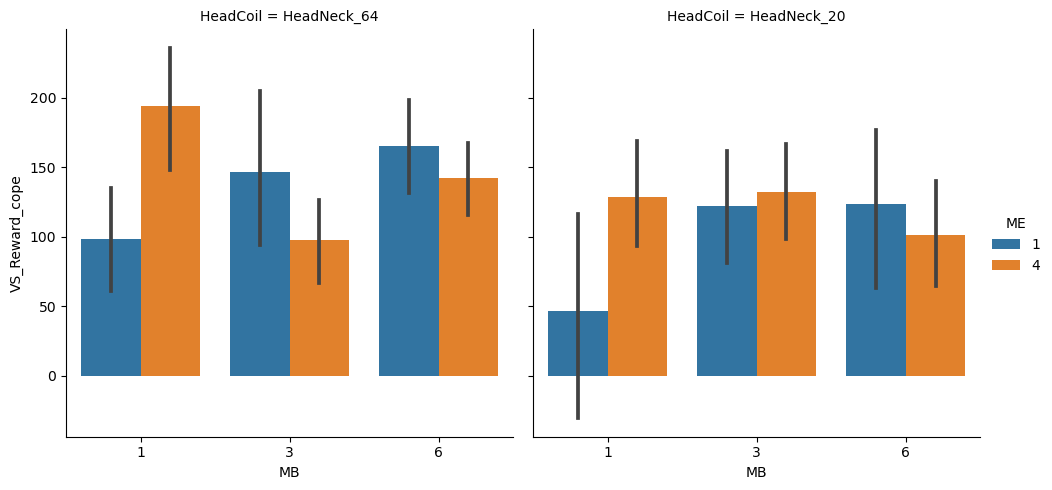

In [8]:
import statsmodels.formula.api as smf
plt_df=subs.dropna()

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('VS_Reward_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('VS_Reward_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('VS_Reward_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())

sns.catplot(x='MB',y='VS_Reward_zstats',hue='ME',data=plt_df,kind='bar',ci=68,
            order=[1,3,6],col='HeadCoil')

plt.savefig("../derivatives/figures/assets/Reward_VS-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('VS_Reward_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='VS_Reward_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.savefig("../derivatives/figures/assets/Reward_VS-act_cope.svg")

plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('VS_Reward_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.savefig("../derivatives/figures/assets/Reward_VS-act_varcope.svg")
#plt.show()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi,VS_Reward_cope,VS_Reward_zstats,VS_Reward_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,3,1,False,False,False,327.953735,1.291766,81046.421875
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,6,4,False,False,False,175.790710,0.558407,92241.953125
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,1,1,False,False,False,-6.943519,0.089437,283341.625000
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,3,4,False,False,False,81.670906,0.271775,92493.953125
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,1,4,False,False,False,17.223320,0.091128,218973.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,32,sub-12042,mb3me1,0,0.882717,0.166905,False,False,False,HeadNeck_20,3,1,False,False,False,147.772766,0.417614,153215.093750
186,33,sub-12042,mb6me4,0,0.465247,0.086336,False,False,False,HeadNeck_20,6,4,False,False,False,181.291000,0.462681,191288.437500
187,34,sub-12042,mb1me4,0,0.384643,0.091856,False,False,False,HeadNeck_20,1,4,False,False,False,221.885605,0.428697,368392.187500
188,35,sub-12042,mb6me1,0,0.562190,0.120174,False,False,False,HeadNeck_20,6,1,False,False,False,12.306326,-0.005160,112309.117188


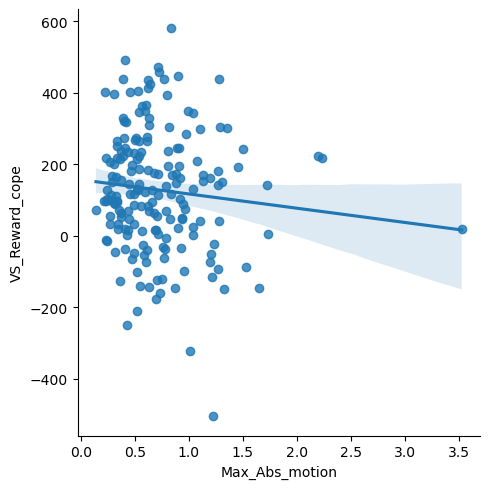

In [9]:
display(plt_df)
sns.lmplot(x='Max_Abs_motion',y='VS_Reward_cope',data=plt_df)

# FFA-Face Activiation

In [10]:
masker= NiftiMasker(mask_img=FFA_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope11.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/zstat11.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope11.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(FFA_face_cope=copes,
               FFA_face_zstats=zstats,
               FFA_face_varcope=varcopes)

100%|█████████████████████████████████████████| 190/190 [02:26<00:00,  1.30it/s]


# Display Face Activation by Acquisition (FFA)

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_face_zstats
No. Observations: 108     Method:             REML           
No. Groups:       18      Scale:              0.5587         
Min. group size:  6       Log-Likelihood:     -135.3311      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
---------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
---------------------------------------------------------------
Intercept    0.404      0.277   1.459   0.145   -0.139    0.948
MB           0.102      0.068   1.504   0.133   -0.031    0.236
ME           0.025      0.091   0.275   0.783   -0.154    0.204
MB:ME        0.000      0.023   0.002   0.998   -0.046    0.046
Group Var    0.105      0.099                                  
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_face_cope
No. Observations: 108     Method:             REML         
No. Groups:       18      Scale:              46630.8725   
Min. group size:  6       Log-Likelihood:     -723.9855    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     182.171   79.662  2.287 0.022  26.037 338.305
MB             -4.498   19.655 -0.229 0.819 -43.021  34.025
ME             -6.343   26.399 -0.240 0.810 -58.083  45.397
MB:ME           4.648    6.742  0.689 0.491  -8.565  17.861
Group Var    7603.848   34.900                             
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_face_zstats
No. Observations: 75      Method:             REML           
No. Groups:       13      Scale:              0.6826         
Min. group size:  5       Log-Likelihood:     -101.7653      
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.630     0.368   1.713  0.087  -0.091   1.352
MB              0.020     0.090   0.217  0.828  -0.157   0.196
ME             -0.013     0.121  -0.106  0.915  -0.251   0.225
MB:ME          -0.022     0.031  -0.696  0.486  -0.082   0.039
Group Var       0.101     0.117                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_face_cope
No. Observations: 75      Method:             REML         
No. Groups:       13      Scale:              108205.3909  
Min. group size:  5       Log-Likelihood:     -524.7758    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
-----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    234.621  143.677  1.633 0.102  -46.981 516.223
MB             1.344   35.883  0.037 0.970  -68.985  71.674
ME           -13.891   48.316 -0.288 0.774 -108.589  80.807
MB:ME         -7.496   12.341 -0.607 0.544  -31.684  16.693
Group Var   5901.867   32.843                              
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    FFA_face_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.6089         
Min. group size:       5          Log-Likelihood:        -237.4652      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.632    0.349  1.810 0.070 -0.052  1.316
HeadCoil[T.HeadNeck_64]       -0.227    0.453 -0.502 0.615 -1.115  0.660
MB                             0.019    0.085  0.226 0.821 -0.148  0.186
MB:HeadCoil[T.HeadNeck_64]     0.083    0.111  0.748 0.454 -0.134  0.300
ME                            -0.013    0.115 -0.117 0.907 -0.238  0.211
ME:HeadCoil[T.HeadNeck_64]     0.038    0.149  0.258 0.796 -0.254  0.331
MB:ME                         -0.022    0.029 -0.734 0.463 -0.079  0.036
MB:ME:HeadCoil[T.HeadNeck_64]  0.022    0.038  0.566 0.572 -0.053  0.096
Group Var                      0.103    0.076                           
========================================================================

"""

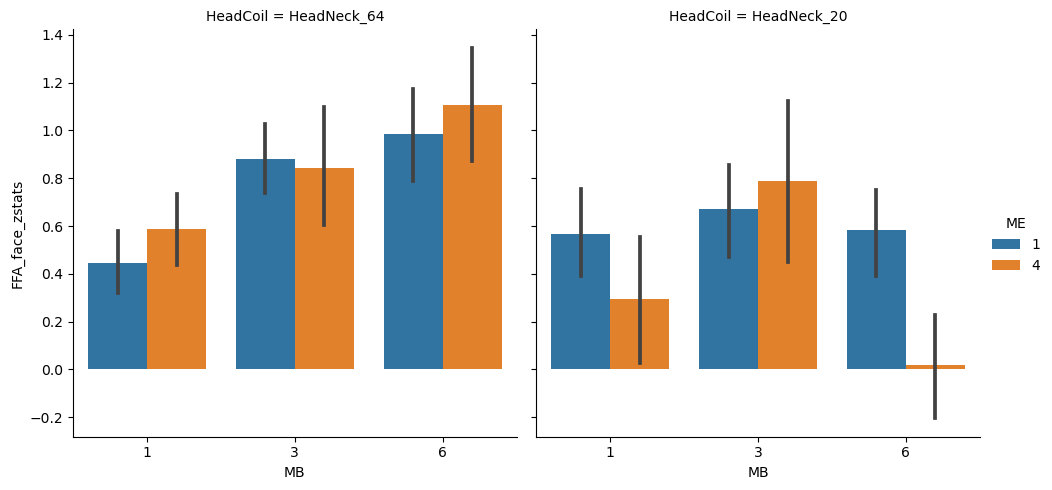

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                  MixedLM       Dependent Variable:       FFA_face_cope
No. Observations:       183           Method:                   REML         
No. Groups:             31            Scale:                    72710.1802   
Min. group size:        5             Log-Likelihood:           -1255.1424   
Max. group size:        6             Converged:                Yes          
Mean group size:        5.9                                                  
-----------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                      234.798  118.094  1.988 0.047    3.338 466.257
HeadCoil[T.HeadNeck_64]        -52.627  153.145 -0.344 0.731 -352.786 247.533
MB                               1.303   29.417  0.044 0.965  -56.354  58.960
MB:HeadCoil[T.HeadNeck_64]      -5.801   38.311 -0.151 0.880  -80.890  69.288
ME                             -14.002   39.609 -0.353 0.724  -91.634  63.631
ME:HeadCoil[T.HeadNeck_64]       7.659   51.532  0.149 0.882  -93.342 108.659
MB:ME                           -7.467   10.117 -0.738 0.460  -27.296  12.362
MB:ME:HeadCoil[T.HeadNeck_64]   12.115   13.161  0.921 0.357  -13.680  37.911
Group Var                     4875.785   18.211                              
=============================================================================

"""

<Figure size 640x480 with 0 Axes>

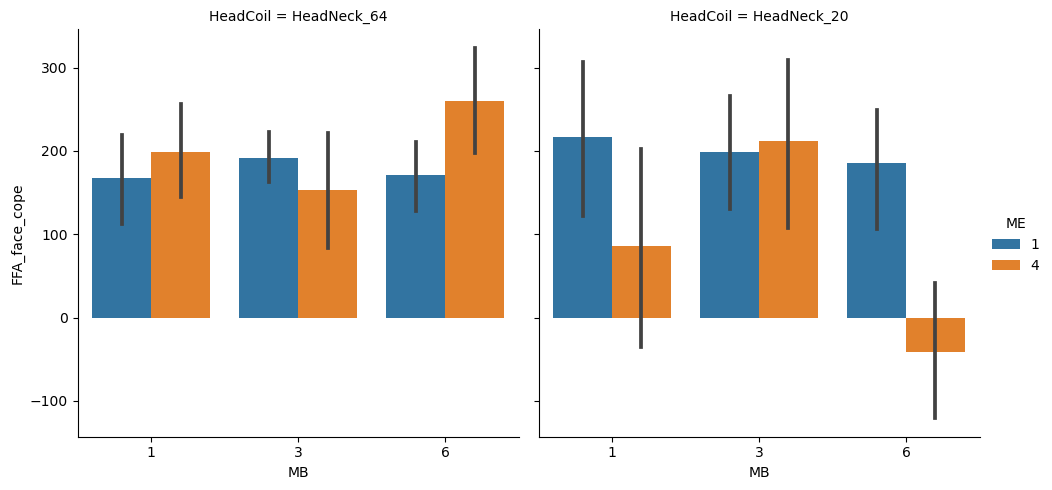

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
import statsmodels.formula.api as smf
plt_df=subs.dropna()

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('FFA_face_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('FFA_face_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('FFA_face_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('FFA_face_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('FFA_face_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='FFA_face_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_varcope.svg")


# Central Gyrus-Button Activiation

In [12]:
masker= NiftiMasker(mask_img=motor_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(Motor_LR_cope=copes,
               Motor_LR_zstats=zstats,
               Motor_LR_varcope=varcopes)

100%|█████████████████████████████████████████| 190/190 [02:43<00:00,  1.16it/s]


# Display Motor Activation by Acquisition

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 108     Method:             REML           
No. Groups:       18      Scale:              0.4633         
Min. group size:  6       Log-Likelihood:     -136.0136      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.678     0.293   2.318  0.020   0.105   1.252
MB              0.215     0.062   3.462  0.001   0.093   0.336
ME              0.056     0.083   0.676  0.499  -0.107   0.219
MB:ME          -0.021     0.021  -0.990  0.322  -0.063   0.021
Group Var       0.482     0.308                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 108     Method:             REML         
No. Groups:       18      Scale:              20855.4903   
Min. group size:  6       Log-Likelihood:     -691.6596    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     210.777   60.220  3.500 0.000  92.747 328.806
MB             12.257   13.145  0.932 0.351 -13.506  38.020
ME             21.965   17.654  1.244 0.213 -12.637  56.567
MB:ME          -3.985    4.509 -0.884 0.377 -12.822   4.852
Group Var   17589.545   54.703                             
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 75      Method:             REML           
No. Groups:       13      Scale:              0.4473         
Min. group size:  5       Log-Likelihood:     -94.2519       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.720     0.342   2.107  0.035   0.050   1.389
MB              0.176     0.073   2.404  0.016   0.032   0.319
ME              0.129     0.098   1.309  0.190  -0.064   0.322
MB:ME          -0.035     0.025  -1.373  0.170  -0.084   0.015
Group Var       0.424     0.334                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 75      Method:             REML         
No. Groups:       13      Scale:              60627.5871   
Min. group size:  5       Log-Likelihood:     -513.4633    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     383.603  124.739  3.075 0.002 139.118 628.088
MB              3.368   26.912  0.125 0.900 -49.379  56.115
ME             22.006   36.250  0.607 0.544 -49.042  93.055
MB:ME          -1.320    9.258 -0.143 0.887 -19.465  16.826
Group Var   54267.090  117.960                             
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    Motor_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.4568         
Min. group size:       5          Log-Likelihood:        -230.2993      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.720    0.348  2.069 0.039  0.038  1.402
HeadCoil[T.HeadNeck_64]       -0.042    0.452 -0.092 0.927 -0.928  0.845
MB                             0.176    0.074  2.378 0.017  0.031  0.320
MB:HeadCoil[T.HeadNeck_64]     0.039    0.096  0.404 0.686 -0.150  0.227
ME                             0.129    0.099  1.294 0.195 -0.066  0.324
ME:HeadCoil[T.HeadNeck_64]    -0.073    0.129 -0.561 0.575 -0.326  0.181
MB:ME                         -0.034    0.025 -1.357 0.175 -0.084  0.015
MB:ME:HeadCoil[T.HeadNeck_64]  0.013    0.033  0.407 0.684 -0.051  0.078
Group Var                      0.458    0.227                           
========================================================================

"""

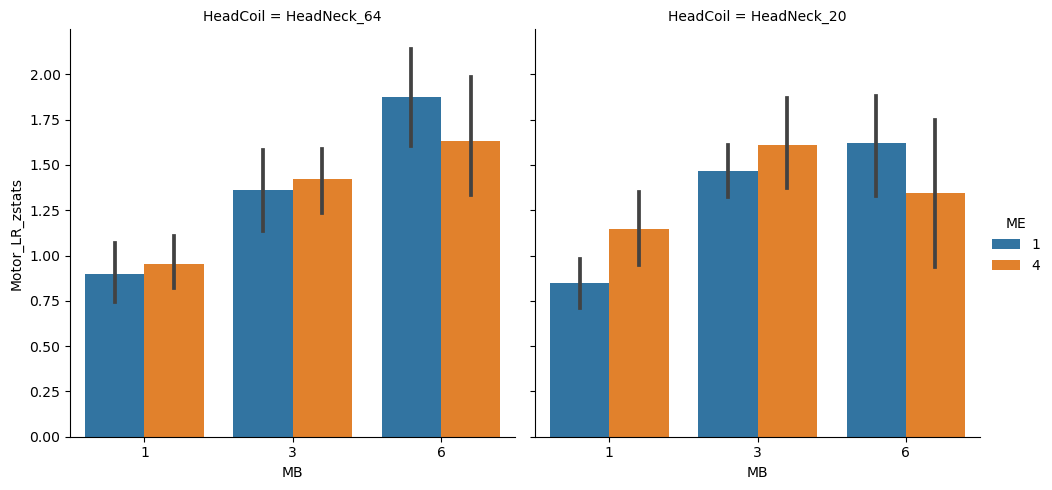

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       Motor_LR_cope
No. Observations:        183           Method:                   REML         
No. Groups:              31            Scale:                    36942.5740   
Min. group size:         5             Log-Likelihood:           -1217.5739   
Max. group size:         6             Converged:                Yes          
Mean group size:         5.9                                                  
------------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                       383.583   97.244  3.945 0.000  192.988 574.177
HeadCoil[T.HeadNeck_64]        -172.806  126.367 -1.367 0.171 -420.480  74.868
MB                                3.373   21.007  0.161 0.872  -37.800  44.547
MB:HeadCoil[T.HeadNeck_64]        8.884   27.338  0.325 0.745  -44.697  62.465
ME                               22.018   28.295  0.778 0.436  -33.439  77.476
ME:HeadCoil[T.HeadNeck_64]       -0.053   36.779 -0.001 0.999  -72.139  72.033
MB:ME                            -1.323    7.226 -0.183 0.855  -15.487  12.840
MB:ME:HeadCoil[T.HeadNeck_64]    -2.662    9.393 -0.283 0.777  -21.071  15.748
Group Var                     32748.115   58.519                              
==============================================================================

"""

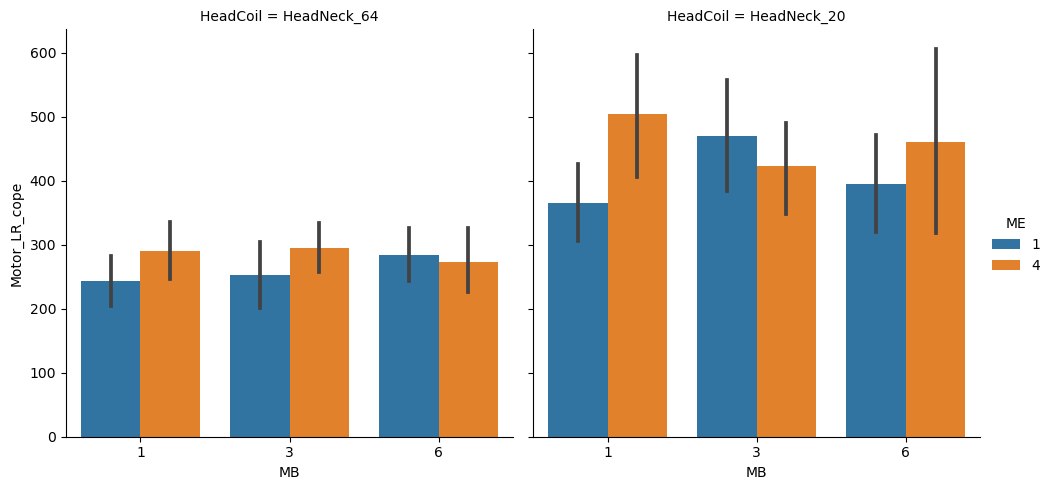

In [13]:
import statsmodels.formula.api as smf
plt_df=subs.dropna()

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('Motor_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('Motor_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('Motor_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/Motor_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('Motor_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/Motor_LR-act_cope.svg")
plt.show()


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

#plt.savefig("../derivatives/figures/assets/Motor_LR-act_varcope.svg")
#plt.show()

# Central ICerbt-Button Activiation

In [14]:
masker= NiftiMasker(mask_img=iCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(iCerb_LR_cope=copes,
               iCerb_LR_zstats=zstats,
               iCerb_LR_varcope=varcopes)

100%|█████████████████████████████████████████| 190/190 [02:25<00:00,  1.31it/s]


# Display Inferior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_LR_zstats
No. Observations: 108     Method:             REML           
No. Groups:       18      Scale:              0.2848         
Min. group size:  6       Log-Likelihood:     -106.7361      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.334     0.213   1.567  0.117  -0.084   0.752
MB              0.169     0.049   3.469  0.001   0.073   0.264
ME              0.074     0.065   1.135  0.256  -0.054   0.202
MB:ME          -0.023     0.017  -1.403  0.161  -0.056   0.009
Group Var       0.168     0.151                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: iCerb_LR_cope
No. Observations: 108     Method:             REML         
No. Groups:       18      Scale:              37681.8177   
Min. group size:  6       Log-Likelihood:     -719.7142    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     220.546   77.303  2.853 0.004  69.035 372.057
MB              9.459   17.669  0.535 0.592 -25.170  44.089
ME             13.009   23.731  0.548 0.584 -33.502  59.521
MB:ME          -3.278    6.060 -0.541 0.589 -15.156   8.600
Group Var   21401.576   53.477                             
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_LR_zstats
No. Observations: 75      Method:             REML           
No. Groups:       13      Scale:              0.2919         
Min. group size:  5       Log-Likelihood:     -72.8397       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.271     0.244   1.111  0.267  -0.207   0.750
MB              0.130     0.059   2.210  0.027   0.015   0.246
ME              0.087     0.079   1.096  0.273  -0.069   0.243
MB:ME          -0.026     0.020  -1.273  0.203  -0.066   0.014
Group Var       0.065     0.094                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: iCerb_LR_cope
No. Observations: 75      Method:             REML         
No. Groups:       13      Scale:              44697.9956   
Min. group size:  5       Log-Likelihood:     -495.2882    
Max. group size:  6       Converged:          No           
Mean group size:  5.8                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     300.486   94.010  3.196 0.001 116.229 484.742
MB            -12.301   23.077 -0.533 0.594 -57.531  32.929
ME            -20.384   31.072 -0.656 0.512 -81.284  40.516
MB:ME           7.489    7.936  0.944 0.345  -8.066  23.044
Group Var    6239.676   35.561                             
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    iCerb_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.2878         
Min. group size:       5          Log-Likelihood:        -180.2681      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.270    0.252  1.072 0.284 -0.224  0.765
HeadCoil[T.HeadNeck_64]        0.064    0.327  0.195 0.845 -0.578  0.705
MB                             0.131    0.059  2.229 0.026  0.016  0.246
MB:HeadCoil[T.HeadNeck_64]     0.038    0.076  0.497 0.619 -0.112  0.187
ME                             0.087    0.079  1.102 0.270 -0.068  0.242
ME:HeadCoil[T.HeadNeck_64]    -0.013    0.103 -0.126 0.900 -0.214  0.188
MB:ME                         -0.026    0.020 -1.284 0.199 -0.065  0.014
MB:ME:HeadCoil[T.HeadNeck_64]  0.003    0.026  0.096 0.924 -0.049  0.054
Group Var                      0.125    0.093                           
========================================================================

"""

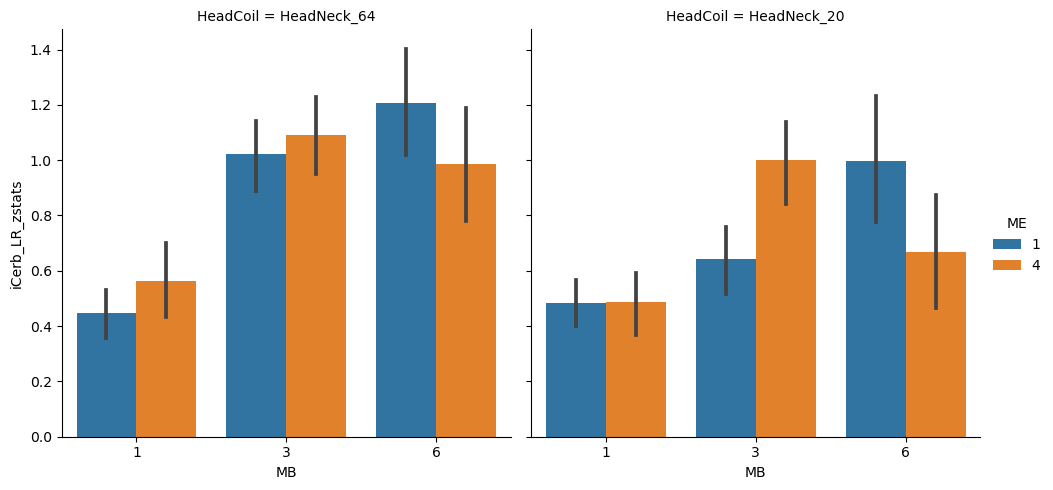

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       iCerb_LR_cope
No. Observations:        183           Method:                   REML         
No. Groups:              31            Scale:                    41094.5635   
Min. group size:         5             Log-Likelihood:           -1216.4994   
Max. group size:         6             Converged:                Yes          
Mean group size:         5.9                                                  
------------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                       299.613   93.782  3.195 0.001  115.805 483.422
HeadCoil[T.HeadNeck_64]         -79.067  121.676 -0.650 0.516 -317.547 159.413
MB                              -12.171   22.142 -0.550 0.583  -55.569  31.228
MB:HeadCoil[T.HeadNeck_64]       21.630   28.823  0.750 0.453  -34.861  78.121
ME                              -20.502   29.819 -0.688 0.492  -78.946  37.941
ME:HeadCoil[T.HeadNeck_64]       33.512   38.772  0.864 0.387  -42.481 109.504
MB:ME                             7.552    7.615  0.992 0.321   -7.375  22.478
MB:ME:HeadCoil[T.HeadNeck_64]   -10.829    9.902 -1.094 0.274  -30.237   8.578
Group Var                     14215.640   29.918                              
==============================================================================

"""

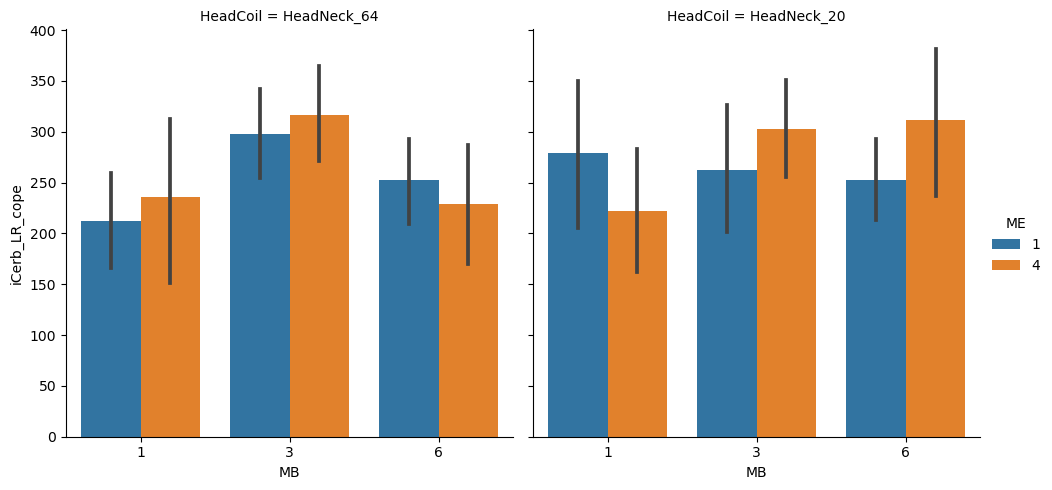

<Figure size 640x480 with 0 Axes>

In [15]:
import statsmodels.formula.api as smf
plt_df=subs.dropna()
for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('iCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('iCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('iCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='iCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_varcope.svg")
plt.show()

# SCerb-Button Activiation

In [16]:
masker= NiftiMasker(mask_img=sCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(SCerb_LR_cope=copes,
               SCerb_LR_zstats=zstats,
               SCerb_LR_varcope=varcopes)

100%|█████████████████████████████████████████| 190/190 [02:28<00:00,  1.28it/s]


# Display Superior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: SCerb_LR_zstats
No. Observations: 108     Method:             REML           
No. Groups:       18      Scale:              0.3039         
Min. group size:  6       Log-Likelihood:     -107.3182      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.391     0.212  -1.843  0.065  -0.807   0.025
MB             -0.091     0.050  -1.812  0.070  -0.189   0.007
ME             -0.029     0.067  -0.432  0.666  -0.161   0.103
MB:ME          -0.004     0.017  -0.258  0.796  -0.038   0.029
Group Var       0.115     0.113                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: SCerb_LR_cope
No. Observations: 108     Method:             REML         
No. Groups:       18      Scale:              41856.2701   
Min. group size:  6       Log-Likelihood:     -717.4536    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept   -227.793   74.953 -3.039 0.002 -374.698 -80.887
MB             9.016   18.622  0.484 0.628  -27.482  45.513
ME             8.013   25.011  0.320 0.749  -41.007  57.033
MB:ME         -7.971    6.387 -1.248 0.212  -20.489   4.548
Group Var   5417.124   22.717                              
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: SCerb_LR_zstats
No. Observations: 75      Method:             REML           
No. Groups:       13      Scale:              0.2359         
Min. group size:  5       Log-Likelihood:     -68.4232       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.356     0.231  -1.544  0.123  -0.808   0.096
MB             -0.070     0.053  -1.327  0.185  -0.174   0.034
ME             -0.015     0.071  -0.204  0.839  -0.155   0.126
MB:ME           0.001     0.018   0.077  0.939  -0.034   0.037
Group Var       0.116     0.144                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: SCerb_LR_cope
No. Observations: 75      Method:             REML         
No. Groups:       13      Scale:              49468.6464   
Min. group size:  5       Log-Likelihood:     -501.3793    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    -104.094  102.053 -1.020 0.308 -304.114 95.926
MB            -22.005   24.293 -0.906 0.365  -69.620 25.609
ME            -19.593   32.716 -0.599 0.549  -83.715 44.529
MB:ME           0.840    8.356  0.101 0.920  -15.538 17.218
Group Var   14895.545   46.728                             
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    SCerb_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.2764         
Min. group size:       5          Log-Likelihood:        -176.3022      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.356    0.246 -1.443 0.149 -0.838  0.127
HeadCoil[T.HeadNeck_64]       -0.035    0.320 -0.110 0.912 -0.662  0.591
MB                            -0.071    0.057 -1.229 0.219 -0.183  0.042
MB:HeadCoil[T.HeadNeck_64]    -0.020    0.075 -0.272 0.785 -0.167  0.126
ME                            -0.015    0.077 -0.191 0.848 -0.166  0.137
ME:HeadCoil[T.HeadNeck_64]    -0.014    0.101 -0.142 0.887 -0.211  0.183
MB:ME                          0.001    0.020  0.074 0.941 -0.037  0.040
MB:ME:HeadCoil[T.HeadNeck_64] -0.006    0.026 -0.230 0.818 -0.056  0.044
Group Var                      0.115    0.088                           
========================================================================

"""

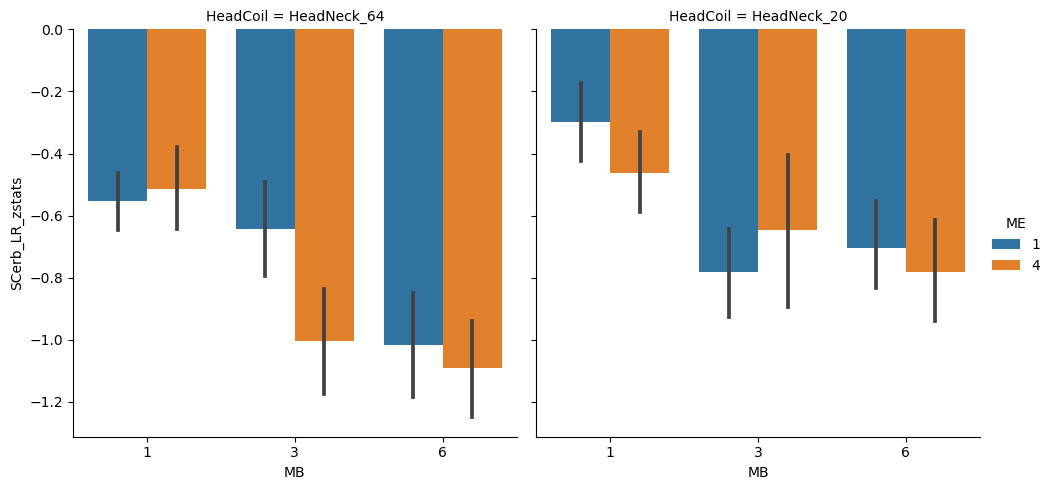

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                  MixedLM       Dependent Variable:       SCerb_LR_cope
No. Observations:       183           Method:                   REML         
No. Groups:             31            Scale:                    44934.7850   
Min. group size:        5             Log-Likelihood:           -1219.7758   
Max. group size:        6             Converged:                Yes          
Mean group size:        5.9                                                  
-----------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                     -103.402   95.536 -1.082 0.279 -290.649  83.845
HeadCoil[T.HeadNeck_64]       -124.391  123.906 -1.004 0.315 -367.242 118.460
MB                             -22.178   23.146 -0.958 0.338  -67.543  23.187
MB:HeadCoil[T.HeadNeck_64]      31.194   30.133  1.035 0.301  -27.866  90.253
ME                             -19.883   31.168 -0.638 0.524  -80.972  41.205
ME:HeadCoil[T.HeadNeck_64]      27.896   40.534  0.688 0.491  -51.549 107.342
MB:ME                            0.935    7.961  0.117 0.907  -14.668  16.538
MB:ME:HeadCoil[T.HeadNeck_64]   -8.905   10.352 -0.860 0.390  -29.196  11.385
Group Var                     9313.714   22.848                              
=============================================================================

"""

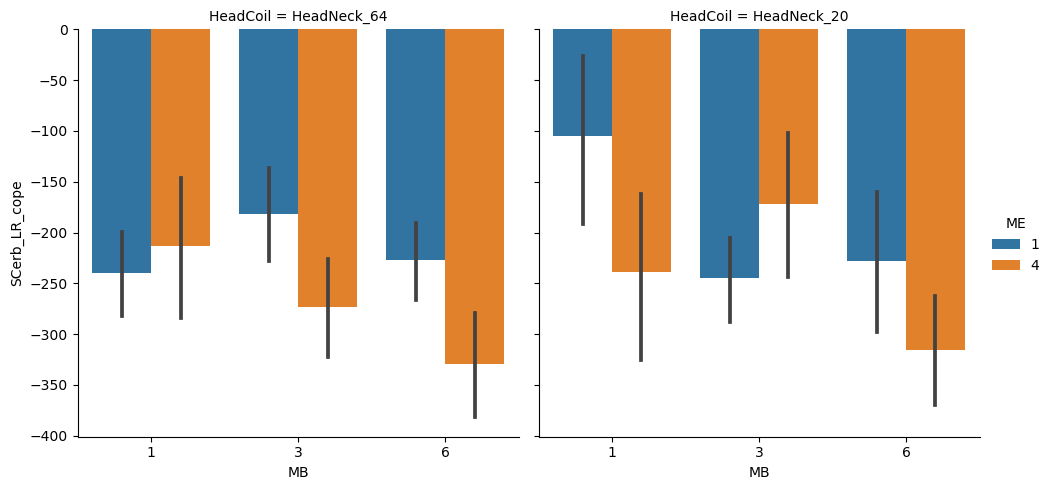

In [17]:
import statsmodels.formula.api as smf
plt_df=subs.dropna()

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('SCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('SCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('SCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('SCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('SCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='SCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

#plt.savefig("../derivatives/figures/assets/sCerb_LR-act_varcope.svg")
#plt.show()

# vmPFC

In [18]:
masker= NiftiMasker(mask_img=pfc_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/cope13.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/tstat13.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4_denoising-base.feat/stats/varcope13.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(pfc_act_cope=copes,
               pfc_act_zstats=zstats,
               pfc_act_varcope=varcopes)

100%|█████████████████████████████████████████| 190/190 [02:25<00:00,  1.31it/s]


# Display vmPFC

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: pfc_act_zstats
No. Observations: 108     Method:             REML          
No. Groups:       18      Scale:              0.3820        
Min. group size:  6       Log-Likelihood:     -109.1501     
Max. group size:  6       Converged:          Yes           
Mean group size:  6.0                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -0.044     0.220  -0.202  0.840  -0.476   0.387
MB             0.072     0.056   1.274  0.203  -0.039   0.182
ME             0.048     0.076   0.632  0.528  -0.100   0.196
MB:ME          0.004     0.019   0.190  0.849  -0.034   0.041
Group Var      0.000     0.042                               
============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: pfc_act_cope
No. Observations: 108     Method:             REML        
No. Groups:       18      Scale:              32219.9212  
Min. group size:  6       Log-Likelihood:     -698.9629   
Max. group size:  6       Converged:          Yes         
Mean group size:  6.0                                     
-----------------------------------------------------------
           Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------
Intercept  25.715    63.976  0.402  0.688  -99.675  151.106
MB          7.763    16.338  0.475  0.635  -24.259   39.785
ME          1.923    21.944  0.088  0.930  -41.085   44.932
MB:ME       2.114     5.604  0.377  0.706   -8.869   13.098
Group Var   0.000    20.551                                
==========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: pfc_act_zstats
No. Observations: 75      Method:             REML          
No. Groups:       13      Scale:              0.3728        
Min. group size:  5       Log-Likelihood:     -78.3482      
Max. group size:  6       Converged:          Yes           
Mean group size:  5.8                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -0.032     0.267  -0.120  0.904  -0.555   0.491
MB             0.061     0.067   0.917  0.359  -0.069   0.192
ME             0.093     0.090   1.041  0.298  -0.082   0.269
MB:ME         -0.016     0.023  -0.711  0.477  -0.061   0.029
Group Var      0.022     0.063                               
============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: pfc_act_cope
No. Observations: 75      Method:             REML        
No. Groups:       13      Scale:              40078.7310  
Min. group size:  5       Log-Likelihood:     -491.2307   
Max. group size:  6       Converged:          Yes         
Mean group size:  5.8                                     
----------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    11.000   88.862  0.124 0.901 -163.165 185.165
MB           14.042   21.854  0.643 0.521  -28.791  56.876
ME           34.258   29.421  1.164 0.244  -23.407  91.923
MB:ME        -6.159    7.515 -0.820 0.412  -20.887   8.570
Group Var  5213.026   26.946                              
==========================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM     Dependent Variable:     pfc_act_zstats
No. Observations:     183         Method:                 REML          
No. Groups:           31          Scale:                  0.3818        
Min. group size:      5           Log-Likelihood:         -187.6989     
Max. group size:      6           Converged:              Yes           
Mean group size:      5.9                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.034    0.267 -0.128 0.898 -0.558  0.490
HeadCoil[T.HeadNeck_64]       -0.010    0.347 -0.030 0.976 -0.690  0.670
MB                             0.062    0.067  0.915 0.360 -0.070  0.194
MB:HeadCoil[T.HeadNeck_64]     0.010    0.088  0.114 0.909 -0.162  0.182
ME                             0.093    0.091  1.030 0.303 -0.084  0.271
ME:HeadCoil[T.HeadNeck_64]    -0.046    0.118 -0.387 0.699 -0.277  0.186
MB:ME                         -0.016    0.023 -0.712 0.477 -0.062  0.029
MB:ME:HeadCoil[T.HeadNeck_64]  0.020    0.030  0.669 0.504 -0.039  0.079
Group Var                      0.005    0.033                           
========================================================================

"""

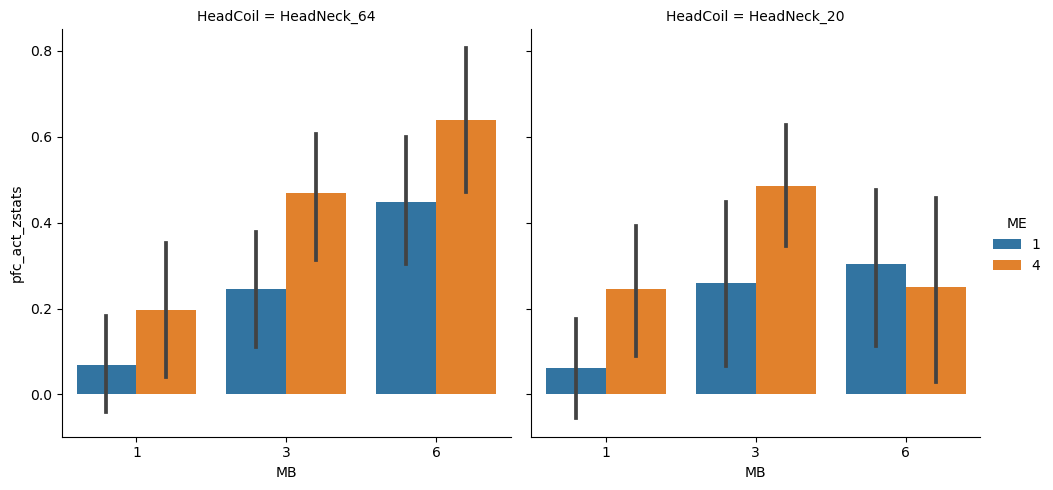

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                  MixedLM       Dependent Variable:       pfc_act_cope
No. Observations:       183           Method:                   REML        
No. Groups:             31            Scale:                    36700.7969  
Min. group size:        5             Log-Likelihood:           -1192.2356  
Max. group size:        6             Converged:                Yes         
Mean group size:        5.9                                                 
----------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------------
Intercept                       8.663   83.083  0.104 0.917 -154.177 171.503
HeadCoil[T.HeadNeck_64]        17.052  107.746  0.158 0.874 -194.126 228.230
MB                             14.550   20.893  0.696 0.486  -26.399  55.499
MB:HeadCoil[T.HeadNeck_64]     -6.787   27.213 -0.249 0.803  -60.124  46.549
ME                             34.547   28.122  1.228 0.219  -20.571  89.665
ME:HeadCoil[T.HeadNeck_64]    -32.623   36.597 -0.891 0.373 -104.352  39.105
MB:ME                          -6.268    7.183 -0.873 0.383  -20.347   7.811
MB:ME:HeadCoil[T.HeadNeck_64]   8.382    9.347  0.897 0.370   -9.938  26.703
Group Var                     796.718   10.522                              
============================================================================

"""

<Figure size 640x480 with 0 Axes>

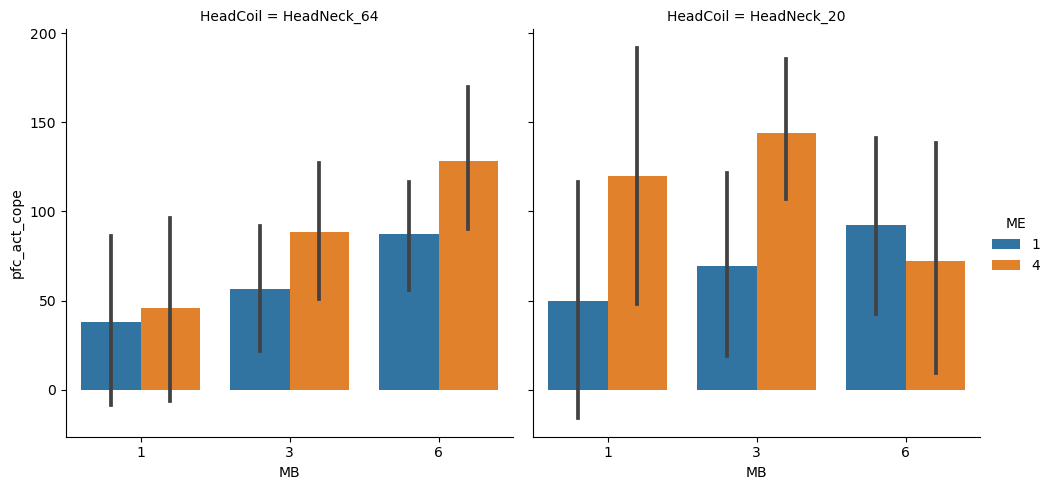

<Figure size 640x480 with 0 Axes>

In [19]:
import statsmodels.formula.api as smf
plt_df=subs.dropna()

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('pfc_act_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('pfc_act_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('pfc_act_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('pfc_act_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('pfc_act_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='pfc_act_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.show()
#plt.savefig("../derivatives/figures/assets/pfc_act-act_varcope.svg")